

<h1>Análisis del fenómeno de histéresis para una muestra de monel</h1>
<p>Para esta experiencia, se estudió la magnetización M de una muestra de monel bajo la influencia de un campo magnético externo H, este último generado mediante un sistema de bobinado.</p>
<p>Utilizando instrumentos de medición como el osciloscopio, un sensor DAQ, y generadores de voltaje para el bobinado, se automatizaron las medidas de M en función de H con Python. Si el campo magnético externo deja de aplicarse (la corriente de las bobinas es nula), la muestra posee una <strong>Magnetización remanente</strong>.</p>
<p>Para el monel, la temperatura se reguló sumergiendo la muestra en nitrógeno líquido. La temperatura es un factor muy importante en este fenómeno, debido a que, al superar un umbral conocido como <strong>Temperatura de Curie</strong>, la sustancia deja de estar magnetizada.</p>

<p>En la experiencia se estudió la magnetización remanente del monel en función de la temperatura, y se estimó la
temperatura de Curie, realizando un ajuste de cuadrados mínimos por la función:</p>
$$M_R (T) = A \cdot (T_C - T)^{\beta}$$
<p>Donde A es una amplitud y $\beta$ es un parámetro mayor que cero.</p>
<p>Paralelamente a este proceso, mediante una Red Neuronal Recurrente, se realizaron predicciones de MR para cierto rango de temperaturas, y se estimó la temperatura de Curie para las predicciones.</p>


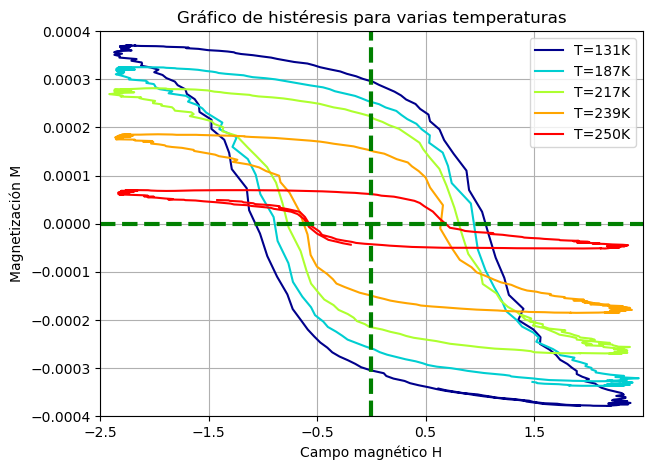

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



#Ploteo de la magnetización M en función del campo magnético H para varias temperaturas
plt.figure(figsize=(7,5))
plt.title("Gráfico de histéresis para varias temperaturas")
temperaturas=['131','187','217','239','250']
colors=['#00008B','#00CED1','#ADFF2F','#FFA500','#FF0000']
c=0
for T in temperaturas:
    ruta=f"dataset histeresis/curvas histeresis/histeresis_T{T}K.csv"
    data=pd.read_csv(ruta)
    #Magnetización y campo magnético
    H=data['H'].values
    M=data['M'].values
    #Cada vector representa varios ciclos de histéresis, por lo que solo hace falta tomar pocos
    H=H[:220]
    M=M[:220]

    #Gráfico de histéresis para todas las temperaturas del monel descritas
    plt.plot(H,M,label=f'T={T}K',color=colors[c])
    c+=1

plt.xlabel("Campo magnético H")
plt.ylabel("Magnetización M")
plt.xlim(-2.5,2.5)
plt.xticks(np.arange(-2.5,2.5,1))
plt.ylim(-0.0004,0.0004)
plt.axhline(y=0, color='green', linestyle='--', linewidth=3)
plt.axvline(x=0, color='green', linestyle='--', linewidth=3)
plt.grid()
plt.legend()
plt.show()


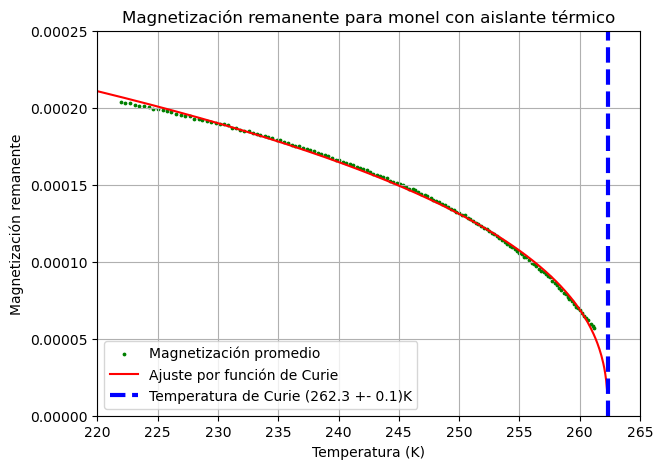

In [99]:
#Cálculo de la magnetización remanente
#Esta misma se estima cuando H=0 (no hay campo externo)
#Las magnetizaciones remanentes son 2, una superior y otra inferior. Ambas se consideran positivas en el csv
#Se calcularon las magnetizaciones remanentes en dos casos: con aislante y sin aislante térmico
#La columna "t" no corresponde al tiempo, sino a otra magnitud medida
#Las columnas importantes son MRinf,MRsup y T (la última está en °C)


#Caso de monel con aislante
ruta=ruta=f"dataset histeresis/magnetizaciones/Temp_MR.csv"
data=pd.read_csv(ruta)
#Tenemos en cuenta la superior y la inferior y calculamos la promedio
T=data['T'].values + 273.15
MRsup=data['MRsup'].values
MRinf=data['MRinf'].values
MRprom=(MRsup+MRinf)/2

#Para hallar la temperatura de Curie, realizamos un ajuste por cuadrados mínimos
from scipy.optimize import curve_fit
def func_Curie(x,Tc,beta,A): #x ---> T
    delta = Tc - x
    delta = np.where(delta > 0, delta, np.nan)  # ignora valores no físicos (donde T>Tc)
    
    return A*(delta**beta)

par,cov=curve_fit(func_Curie, T,MRprom, p0=[300, 0.3, 1])
Tc,beta,A=par
eTc,ebeta,eA=np.sqrt(np.diag(cov))
#print(f"Temperatura de Curie: ({round(Tc,1)} +- {round(eTc,1)}) K")
#print(f"Parámetro A: ({A} +- {eA})")
#print(f"Parámetro beta: ({beta} +- {ebeta}) K")

T_aj=np.linspace(220,300,1000)
M_aj=func_Curie(T_aj,Tc,beta,A)


plt.figure(figsize=(7,5))
plt.title("Magnetización remanente para monel con aislante térmico")
plt.scatter(T,MRprom,label='Magnetización promedio',s=3, color="green")
plt.plot(T_aj,M_aj,label="Ajuste por función de Curie", color="red")
plt.axvline(x=Tc,color="blue",linestyle='--',linewidth=3,label=f'Temperatura de Curie ({round(Tc,1)} +- {round(eTc,1)})K')
plt.xlabel("Temperatura (K)")
plt.ylabel("Magnetización remanente")
plt.xlim(220,265)
plt.ylim(0,0.00025)
plt.legend()
plt.grid()
plt.show()



In [71]:
print(len(MRprom))
training_set=np.reshape(MRprom,(len(MRprom),1))
print(training_set.shape)

149
(149, 1)


In [73]:
#Por medio de una Red neuronal recurrente (RNR), vamos a evaluar el comportamiento a futuro de la magnetización

#Convertimos el array de MRprom en un vector columna (con dos dimensiones)
training_set=np.reshape(MRprom,(len(MRprom),1))
#Esto es para normalización entre 0 y 1 (feature_range) ---> ESCALADO
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
training_set_scaled=sc.fit_transform(training_set)




#Datos de entrenamiento
#Estructura de datos de 60 timesteps y 1 salida
X_train=[]
y_train=[]
#El training set tiene hasta la componente 149
for i in range(60,149):
    #El X_train va a agregar del 0 a 59, luego del 1 al 60, etc
    #Como el training set es una matriz 2D, tomo la "primera columna" 0 (es la unica)
    X_train.append(training_set_scaled[i-60:i , 0])
    #El y_train va a appendear el elemento siguiente a ese conjunto ---> el 60,61,62,etc
    y_train.append(training_set_scaled[i , 0])

#Finalmente los convierto a arrays de numpy (no listas)
X_train,y_train=np.array(X_train),np.array(y_train)

print(X_train.shape) #X_train es una matriz de  89x60
print(len(y_train)) #y_train es un vector de 89 componentes


#Las predicciones van a ser para los instantes siguientes


#Las dimensiones son: batch_size (tamaño del lote), timesteps (numero de pasos), input_dim (numero de dimensiones)
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
#batch_size=89, timesteps=60, input_dim=1 (un vector columna)
print(X_train.shape) # (89,60,1)

(89, 60)
89
(89, 60, 1)


Epoch 1/100
3/3 [==============================] - 11s 92ms/step - loss: 0.1714
Epoch 2/100
3/3 [==============================] - 0s 80ms/step - loss: 0.0429
Epoch 3/100
3/3 [==============================] - 0s 80ms/step - loss: 0.0461
Epoch 4/100
3/3 [==============================] - 0s 80ms/step - loss: 0.0195
Epoch 5/100
3/3 [==============================] - 0s 79ms/step - loss: 0.0268
Epoch 6/100
3/3 [==============================] - 0s 79ms/step - loss: 0.0250
Epoch 7/100
3/3 [==============================] - 0s 81ms/step - loss: 0.0143
Epoch 8/100
3/3 [==============================] - 0s 79ms/step - loss: 0.0167
Epoch 9/100
3/3 [==============================] - 0s 78ms/step - loss: 0.0104
Epoch 10/100
3/3 [==============================] - 0s 78ms/step - loss: 0.0114
Epoch 11/100
3/3 [==============================] - 0s 81ms/step - loss: 0.0084
Epoch 12/100
3/3 [==============================] - 0s 80ms/step - loss: 0.0076
Epoch 13/100
3/3 [==============================

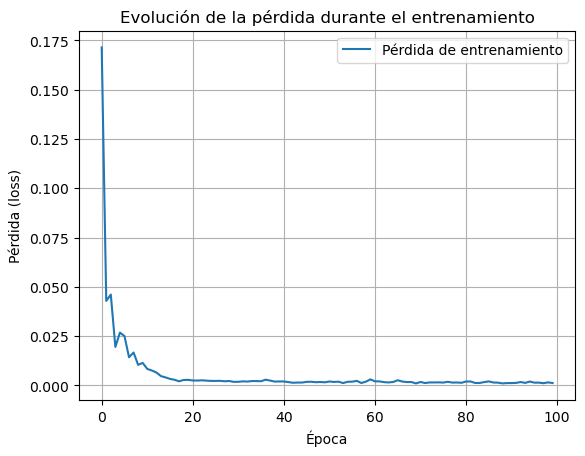

In [100]:
#Iniciamos la RNR
from keras.models import Sequential #Secuencia de capas
#Dense: capas ocultas
#LSTM: Long-Short Term Memory Networks
#Dropout: para regularizar y prevenir el "overfitting"
from keras.layers import Dense,LSTM,Dropout



#Inicio la regresión
regressor=Sequential()

#Agrego una capa de LSTM
#units: 50 (elegimos un valor alto)
#return_sequences: para reutilizar las neuronas del LSTM
#En este caso van a ser 3 capas de LSTM y una capa final
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1) ))
#Porcentaje de neuronas que se van a ignorar en el entrenamiento
regressor.add(Dropout(0.2)) #20% de las LSTM

regressor.add(LSTM(units=50, return_sequences=True ))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True ))
regressor.add(Dropout(0.2))

#Última capa LSTM
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

#Capa de salida ---> 1 neurona para predecir el valor de MR en el instante siguiente
regressor.add(Dense(units=1))




#Compilamos la RNR
#función de pérdida: "mean_squared_error" 
regressor.compile(
    optimizer='adam',
    loss='mean_squared_error'   
)




#Entrenamos el modelo
#El tamaño del lote (batch_size) va a ser 32 en este caso
#regressor.fit(X_train,y_train, epochs=100, batch_size=32)
# Entrenamiento y almacenamiento del historial
history = regressor.fit(X_train, y_train, epochs=100, batch_size=32)

# Gráfico de la función de pérdida con respecto a las "epochs"
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (loss)')
plt.legend()
plt.grid()
plt.show()

#Se puede observar que la pérdida disminuye al entrenar el modelo varias veces y se estabiliza rápidamente.
#No hay señal de overfitting, pues no se observan cambios bruscos en la pérdida.

7/7 [==============================] - 2s 21ms/step


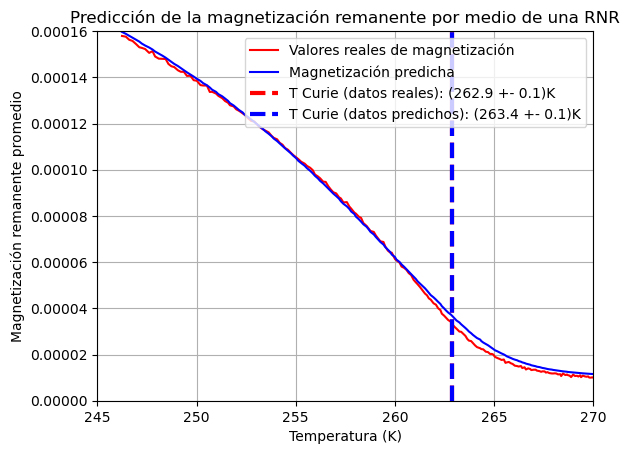

In [101]:
#Tenemos datos de MR medido para un rango mayor de temperaturas al MR utilizado para el entrenamiento
#Predecimos las últimas 200 componentes (el vector tiene 299 componentes)
datos_test=pd.read_csv("dataset histeresis/magnetizaciones/Temp_MR4.csv")
MRprom_test=(datos_test['MRsup'].values + datos_test['MRinf'].values)/2

#Indice a partir del cual tomamos los datos de prueba
split_index=len(MRprom_test) - 200

#Rango de temperaturas para la predicción
T_test=(datos_test['T'].values + 273.15)[split_index:]

# Datos de test
test_set = MRprom_test[split_index-60:]  # Incluye los 60 pasos anteriores para crear X_test
real_M = MRprom_test[split_index:]  # Valores reales que querés predecir

# Normalizar usando el mismo scaler que con los datos de entrenamiento
inputs = np.reshape(test_set, (len(test_set), 1))
inputs_scaled = sc.transform(inputs)

# Armar X_test (con el mismo criterio que con el set de entrenamiento)
X_test = []
for i in range(60, len(inputs_scaled)):
    X_test.append(inputs_scaled[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))



#Predicción
MRpred=regressor.predict(X_test)
#Para comparar con los datos reales, inviertimos la normalización
#También aplanamos el vector para posterior análisis
MRpred=sc.inverse_transform(MRpred).flatten()



#Se realizará el mismo ajuste por cuadrados mínimos para los dos conjuntos de datos
from scipy.optimize import curve_fit
def func_Curie(x,Tc,beta,A): #x ---> T
    delta = Tc - x
    delta = np.where(delta > 0, delta, np.nan)  # ignora valores no físicos (donde T>Tc)
    
    return A*(delta**beta)
#Obtenemos la temperatura de Curie para los dos casos (los vectores deben recortarse para predecir mejor los parámetros)
par1,cov1=curve_fit(func_Curie, T_test[:100],real_M[:100], p0=[300, 0.3, 1]) #para los datos reales
par2,cov2=curve_fit(func_Curie, T_test[:100],MRpred[:100], p0=[300, 0.3, 1]) #para los datos predichos
#Temperaturas de Curie con sus desvíos estándar
Tc1=par1[0]
Tc2=par2[0]
eTc1=np.sqrt(np.diag(cov1))[0]
eTc2=np.sqrt(np.diag(cov2))[0]




#Ahora comparamos los valores de las predicciones con los valores originales
plt.title("Predicción de la magnetización remanente por medio de una RNR")
plt.plot(T_test,real_M,color="red",label="Valores reales de magnetización")
plt.plot(T_test,MRpred,color="blue",label="Magnetización predicha")
plt.axvline(x=Tc1,color="red",linestyle='--',linewidth=3,label=f"T Curie (datos reales): ({round(Tc1,1)} +- {round(eTc1,1)})K")
plt.axvline(x=Tc1,color="blue",linestyle='--',linewidth=3,label=f"T Curie (datos predichos): ({round(Tc2,1)} +- {round(eTc2,1)})K")
plt.xlabel("Temperatura (K)")
plt.ylabel("Magnetización remanente promedio")
plt.xlim(245,270)
plt.ylim(0,0.00016)
plt.legend(loc='upper right')
plt.grid()
plt.show()

In [102]:
#Se pueden obtener parámetros estadísticos para establecer discrepancias entre los datos predichos y los reales
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Error absoluto promedio
mae = mean_absolute_error(real_M, MRpred)
#Error cuadrático medio
rmse = np.sqrt(mean_squared_error(real_M, MRpred))
#Coeficiente de determinación R^2
r2 = r2_score(real_M, MRpred)
print(f"MAE: {mae:.2e}, RMSE: {rmse:.2e}, R^2: {r2:.4f}")

#Los resultados muestran una muy buena predicción del modelo con respecto a los datos reales.
#Esto se ve en los valores de la temperatura de Curie, muy similares

MAE: 1.55e-06, RMSE: 1.84e-06, R^2: 0.9986
